## Langchain Expression Language Basics

In [18]:
from dotenv import load_dotenv

load_dotenv()

True

### Sequential LCEL Chain

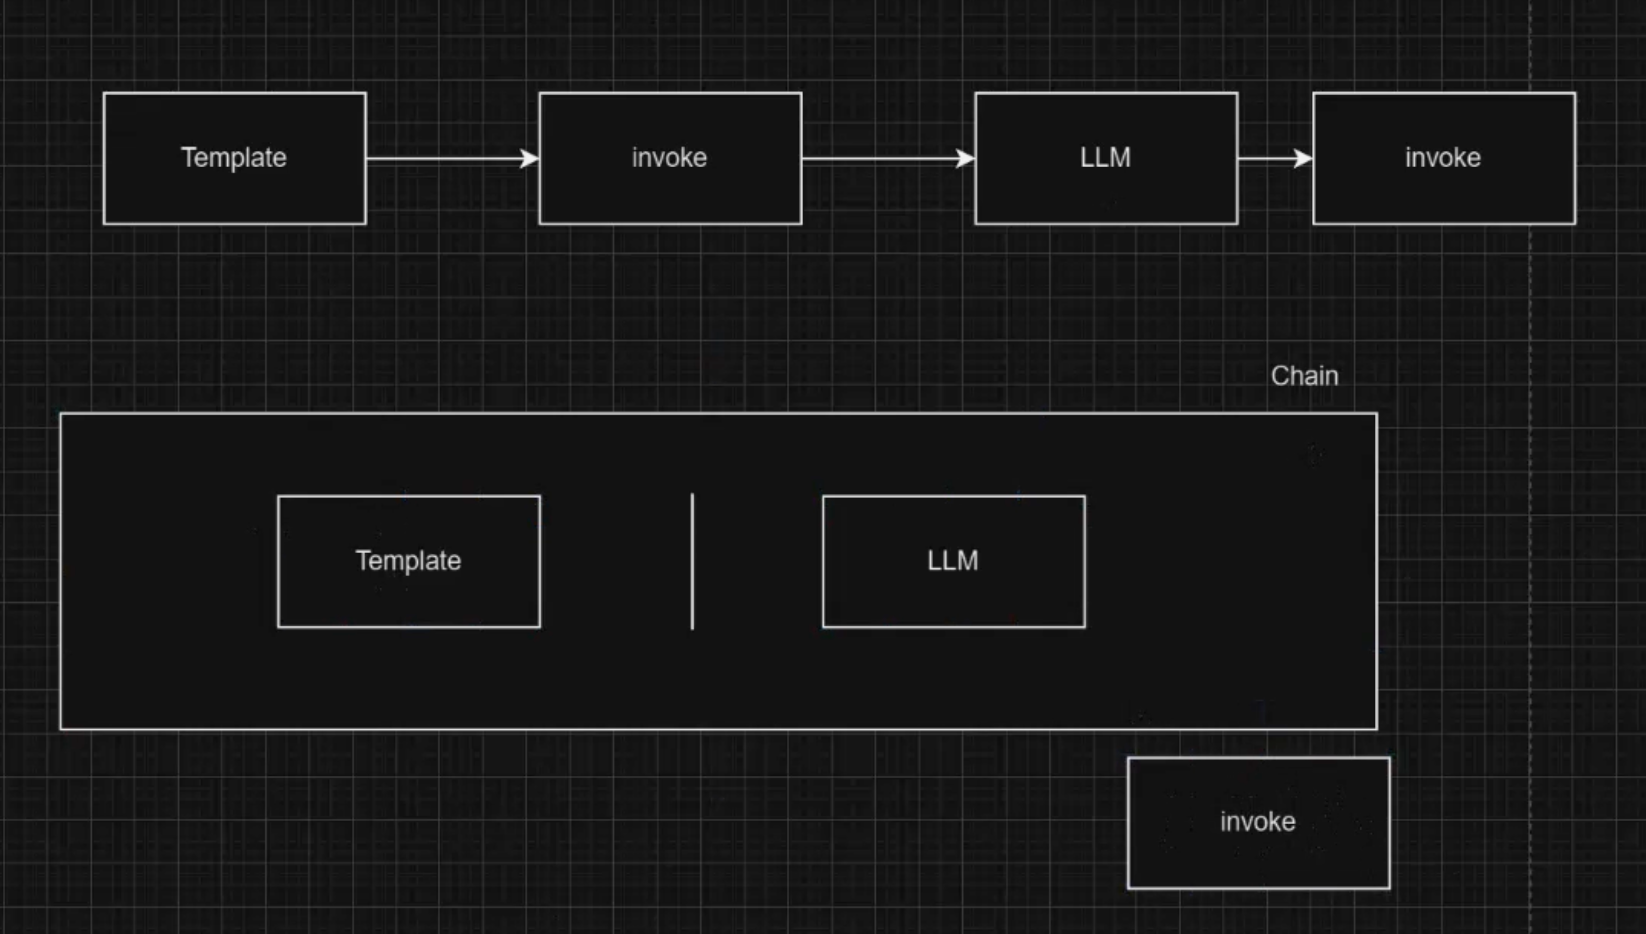

In [3]:
from langchain_ollama import ChatOllama
from langchain_core.prompts import (
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
    ChatPromptTemplate,
)

base_url = "http://localhost:11434/"
model = "llama3.2:latest"

llm = ChatOllama(base_url=base_url, model=model, temperature=0.8, num_predict=256)

/Users/rohit/Workspace/Udemy/LanchainForStreamlit/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
system = SystemMessagePromptTemplate.from_template(
    "You are {school} teacher. You answer in short sentences."
)

question = HumanMessagePromptTemplate.from_template(
    "tell me about the {topics} in {points} points"
)

In [5]:
## two times invoke method called that is not efficient way to do this task
messages=[system, question]
template= ChatPromptTemplate.from_messages(messages)
question= template.invoke({"school": "maths", "topics": "algebra", "points": 3})
response = llm.invoke(question)
print(response.content)

Here's the algebra in 3 points:

1. Algebra is a branch of mathematics that deals with solving equations and manipulating variables.
2. It involves using letters, numbers, and mathematical operations to represent unknown values or quantities.
3. The goal of algebra is to isolate the variable, solve for its value, and find the solution to the equation.


In [6]:
## Efficient way using Chains
## this is called Sequential Chain
chain = template | llm
response = chain.invoke({"school": "maths", "topics": "algebra", "points": 5})
print(response.content)

Here's algebra in 5 key points:

1. Algebra is a branch of mathematics that deals with variables and their relationships.
2. It involves using letters, numbers, and symbols to represent unknown values or expressions.
3. Equations are central to algebra, where unknowns are solved for by isolating them on one side.
4. Solving equations requires applying various techniques, such as factoring, graphing, and quadratic formula.
5. Algebraic expressions can be simplified, expanded, and manipulated using rules and properties of operations.


In [7]:
response

AIMessage(content="Here's algebra in 5 key points:\n\n1. Algebra is a branch of mathematics that deals with variables and their relationships.\n2. It involves using letters, numbers, and symbols to represent unknown values or expressions.\n3. Equations are central to algebra, where unknowns are solved for by isolating them on one side.\n4. Solving equations requires applying various techniques, such as factoring, graphing, and quadratic formula.\n5. Algebraic expressions can be simplified, expanded, and manipulated using rules and properties of operations.", additional_kwargs={}, response_metadata={'model': 'llama3.2:latest', 'created_at': '2025-10-24T08:44:03.972269Z', 'done': True, 'done_reason': 'stop', 'total_duration': 4271592417, 'load_duration': 96080167, 'prompt_eval_count': 45, 'prompt_eval_duration': 1150779375, 'eval_count': 109, 'eval_duration': 2965969376, 'model_name': 'llama3.2:latest'}, id='run--3eef2d3f-cf31-4b7a-8625-4f13a82a898c-0', usage_metadata={'input_tokens': 45

In [8]:
from  langchain_core.output_parsers import StrOutputParser

parser = StrOutputParser()

In [9]:
chain = template | llm | parser
response = chain.invoke({"school": "maths", "topics": "geometry", "points": 4})
print(response)

Here's geometry in 4 key points:

1. Points, Lines, and Planes: Basic elements of geometry.
2. Angles and Measurements: Calculating angles, perimeter, and area.
3. Shapes and Symmetry: Identifying symmetrical figures like squares and triangles.
4. Properties and Theorems: Applying rules like congruent and similar shapes.


### Chaining Runnables (Chain Multiple Runnables)

In [10]:
chain

ChatPromptTemplate(input_variables=['points', 'school', 'topics'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['school'], input_types={}, partial_variables={}, template='You are {school} teacher. You answer in short sentences.'), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['points', 'topics'], input_types={}, partial_variables={}, template='tell me about the {topics} in {points} points'), additional_kwargs={})])
| ChatOllama(model='llama3.2:latest', num_predict=256, temperature=0.8, base_url='http://localhost:11434/')
| StrOutputParser()

In [11]:
analysis_prompt = ChatPromptTemplate.from_template(
    """analyze the following text: {response}
                                                   You need tell me that how difficult it is to understand.
                                                   Answer in one sentence only.
                                                   """
)

fact_check_chain = analysis_prompt | llm | StrOutputParser()
output = fact_check_chain.invoke({"response": response})
print(output)

I would rate the difficulty of understanding this text as moderate, requiring basic knowledge of geometry concepts, but not excessively complex or technical.


In [12]:
composed_chain = chain | fact_check_chain
final_output = composed_chain.invoke(
    {"school": "maths", "topics": "geometry", "points": 4}
)
print(final_output)

The text provides a concise and clear overview of the fundamental concepts of geometry, which can be easily understood by students at various skill levels, with a difficulty level rating of 2/10.


### Parallel LCEL Chain

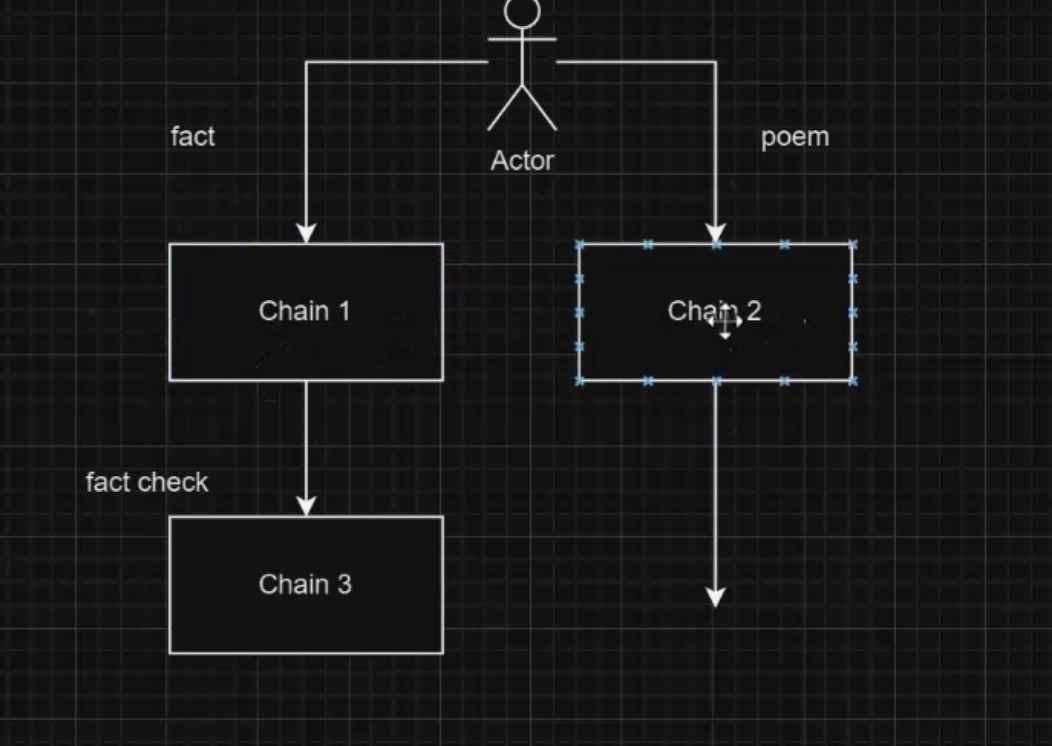

In [13]:
system = SystemMessagePromptTemplate.from_template(
    "You are {school} teacher. You answer in short sentences."
)

question = HumanMessagePromptTemplate.from_template(
    "tell me about the {topics} in {points} points"
)


messages = [system, question]
template = ChatPromptTemplate(messages)
fact_chain = template | llm | StrOutputParser()

output = fact_chain.invoke({"school": "primary", "topics": "solar system", "points": 2})
print(output)

Here are two key points about our Solar System:

1. The Sun is the centre of our Solar System, making up 99.8% of its mass.
2. Our Solar System consists of eight planets: Mercury, Mars, Venus, Earth, Neptune, Uranus, Saturn, and Jupiter, with other smaller objects like moons and asteroids orbiting them.


In [14]:
question = HumanMessagePromptTemplate.from_template(
    "write a poem on {topics} in {sentences} lines"
)


messages = [system, question]
template = ChatPromptTemplate(messages)
poem_chain = template | llm | StrOutputParser()

output = poem_chain.invoke(
    {"school": "primary", "topics": "solar system", "sentences": 2}
)
print(output)

Eight planets dance around the sun,
A celestial show, just begun!


In [15]:
from langchain_core.runnables import RunnableParallel

In [16]:
chain = RunnableParallel(fact=fact_chain, poem=poem_chain)

In [17]:
output = chain.invoke(
    {"school": "primary", "topics": "solar system", "points": 2, "sentences": 2}
)
print(output["fact"])
print("\n\n")
print(output["poem"])

Here's information about the solar system:

1. The solar system has eight planets, including Mercury and Mars.
2. Our sun is at the center of the solar system and orbits around it every year.



Here's a short poem:

Planets dance around the sun,
A beautiful Solar System, just begun!


### Chain Router

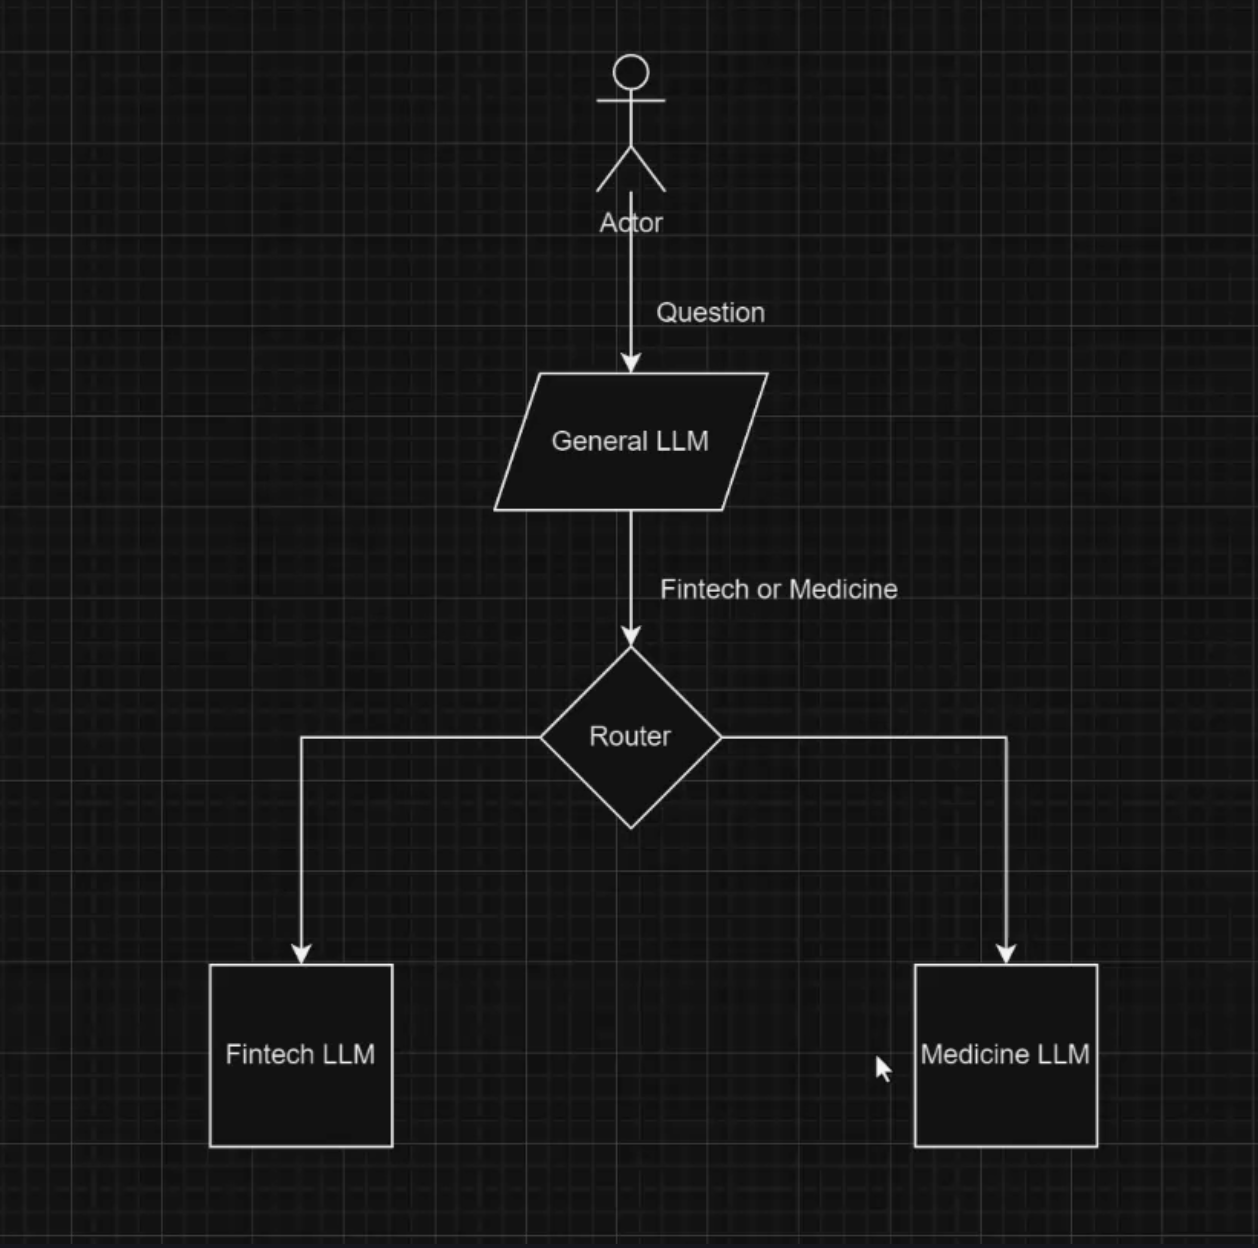

In [21]:
prompt = """Given the user review below, classify it as either being about `Positive` or `Negative`.
            Do not respond with more than one word.

            Review: {review}
            Classification:"""

template = ChatPromptTemplate.from_template(prompt)

chain = template | llm | StrOutputParser()

review = "Thank you so much for providing such a great plateform for learning. I am really happy with the service."
# review = "I am not happy with the service. It is not good."
chain.invoke({"review": review})

'Positive'

In [39]:
positive_prompt = """
                You are expert in writing reply for positive reviews.
                You need to encourage the user to share their experience on social media.
                You need t to format the response in following way:
                'Dear Customer, [your response here]
                Best regards,
                [Your Name]'
                Review: {review}
                Answer:"""

positive_template = ChatPromptTemplate.from_template(positive_prompt)
positive_chain = positive_template | llm | StrOutputParser()

In [36]:
negative_prompt = """
                You are expert in writing reply for negative reviews.
                You need first to apologize for the inconvenience caused to the user.
                You need to encourage the user to share their concern on following Email:'rohit@gmail.com'.
                You need to assure the user that their feedback is valuable and will be taken seriously.
                You need to encourage the user to share their concern on following Email:'rohit@gmail.com'.
                You need to thank the user for their feedback with company name 'TCS'.
                You need to used Rohit as sender name.
                Review: {review}
                Answer:"""


negative_template = ChatPromptTemplate.from_template(negative_prompt)
negative_chain = negative_template | llm | StrOutputParser()

In [27]:
def rout(info):
    if "positive" in info["sentiment"].lower():
        return positive_chain
    else:
        return negative_chain

In [29]:
rout({'sentiment': 'positive'})

ChatPromptTemplate(input_variables=['review'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['review'], input_types={}, partial_variables={}, template='\n                You are expert in writing reply for positive reviews.\n                You need to encourage the user to share their experience on social media.\n                Review: {review}\n                Answer:'), additional_kwargs={})])
| ChatOllama(model='llama3.2:latest', num_predict=256, temperature=0.8, base_url='http://localhost:11434/')
| StrOutputParser()

In [30]:
from langchain_core.runnables import RunnableLambda

In [31]:
full_chain = {"sentiment": chain, "review": lambda x: x["review"]} | RunnableLambda(
    rout
)

In [32]:
full_chain

{
  sentiment: ChatPromptTemplate(input_variables=['review'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['review'], input_types={}, partial_variables={}, template='Given the user review below, classify it as either being about `Positive` or `Negative`.\n            Do not respond with more than one word.\n\n            Review: {review}\n            Classification:'), additional_kwargs={})])
             | ChatOllama(model='llama3.2:latest', num_predict=256, temperature=0.8, base_url='http://localhost:11434/')
             | StrOutputParser(),
  review: RunnableLambda(lambda x: x['review'])
}
| RunnableLambda(rout)

In [40]:
review = "Thank you so much for providing such a great plateform for learning. I am really happy with the service."
# review = "I am not happy with the service. It is not good."

output = full_chain.invoke({"review": review})
print(output)

Dear Customer,

We're absolutely delighted to hear that you're enjoying our platform and finding it helpful for your learning needs! Your satisfaction is what drives us to keep improving, and we're thrilled that you're experiencing such great results.

As a token of appreciation for your kind words, we'd love to see your experience shared with others. Would you mind taking a moment to share a photo or review on your social media channels? A simple post or shoutout can help inspire others to join our community and take advantage of the amazing resources we have to offer.

We're honored to have customers like you who appreciate our platform, and we can't wait to see what the future holds for us!

Best regards,
[Your Name]


### Make Custom Chain Runnables with RunnablePassthrough and RunnableLambda

In [41]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda

In [42]:
def char_counts(text):
    return len(text)


def word_counts(text):
    return len(text.split())


prompt = ChatPromptTemplate.from_template(
    "Explain these inputs in 5 sentences: {input1} and {input2}"
)

In [43]:
prompt

ChatPromptTemplate(input_variables=['input1', 'input2'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input1', 'input2'], input_types={}, partial_variables={}, template='Explain these inputs in 5 sentences: {input1} and {input2}'), additional_kwargs={})])

In [44]:
chain = prompt | llm | StrOutputParser()

output = chain.invoke({"input1": "Earth is planet", "input2": "Sun is star"})

print(output)

The input states that "Earth" is classified as a planet, which is the third planet from the Sun in our solar system. The Sun, on the other hand, is classified as a star, which is a massive ball of hot, glowing gas that provides light and heat to its surrounding planets. In this context, Earth and Sun are the primary celestial bodies being discussed, with their respective roles as a planet and a star taking center stage. This classification highlights their unique characteristics and functions within our solar system. The input essentially establishes a fundamental relationship between two of our most well-known celestial entities: Earth and the Sun.


In [45]:
chain = (
    prompt
    | llm
    | StrOutputParser()
    | {
        "char_counts": RunnableLambda(char_counts),
        "word_counts": RunnableLambda(word_counts),
        "output": RunnablePassthrough(),
    }
)

output = chain.invoke({"input1": "Earth is planet", "input2": "Sun is star"})

print(output)

{'char_counts': 1269, 'word_counts': 212, 'output': "Here are 5-sentence explanations for the two inputs:\n\nThe Earth is a planet, which is a celestial body that orbits around another celestial body due to gravity. It is one of eight planets in our solar system, located at an average distance from the Sun that allows it to maintain liquid water and life-supporting conditions. The Earth's atmosphere, oceans, and landmasses make it habitable for a diverse range of living organisms. As a planet, the Earth is unique in its ability to support complex ecosystems and life forms, making it a fascinating subject of scientific study. Its size, composition, and location have played a crucial role in shaping its environment and the evolution of life on our planet.\n\nThe Sun is a star, which is a massive ball of hot, glowing gas that generates energy through nuclear reactions in its core. Our solar system's primary source of light and heat, the Sun is a G-type main-sequence star, meaning it is ne

### Custom Chain using @chain decorator

In [46]:
from langchain_core.runnables import chain

In [47]:
@chain
def custom_chain(params):
    return {
        "fact": fact_chain.invoke(params),
        "poem": poem_chain.invoke(params),
    }


params = {"school": "primary", "topics": "solar system", "points": 2, "sentences": 2}
output = custom_chain.invoke(params)
print(output["fact"])
print("\n\n")
print(output["poem"])

Here's information about the solar system:

* Our solar system consists of eight planets, including Mercury and Neptune.
* The Sun is at the center, surrounded by the planets, with each planet having its own unique features and characteristics.



Eight planets orbit, shining bright,
A celestial dance through the dark of night.
